# CSE455/552 — Decision Tree & Random Forest (HW 2)

In this assignment, two different datasets were prepared from the Abalone dataset.
The first dataset groups the target variable using pd.qcut to ensure an equal number of samples in each group.
The second dataset manually defines age groups based on the logical meaning of the ring values.
Both datasets were used to train and evaluate decision trees before and after pruning, and results were compared.
Random Forest models were also trained for additional comparison.

**Imports**

In [53]:
from __future__ import annotations

import time
import math
import random
from collections import Counter
from typing import Any, Dict, List, Optional, Sequence

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from scipy.stats import chi2  # for critical values
import matplotlib.pyplot as plt


Loading Dataset and Analyzing

Dataset shape: 4177 rows, 9 columns

First 5 rows:
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Data types:
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

Missing values per column:
Sex               0
Len

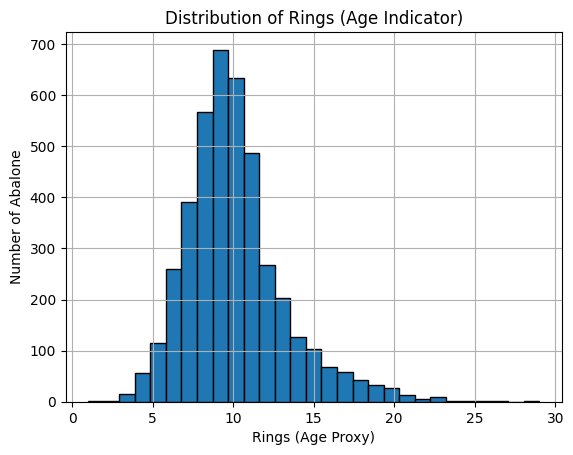

In [ ]:
column_names = [
    'Sex', 'Length', 'Diameter', 'Height',
    'Whole weight', 'Shucked weight',
    'Viscera weight', 'Shell weight', 'Rings',
]
df = pd.read_csv("abalone.data", names=column_names)

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

feature_names = ['Sex', 'Length', 'Diameter', 'Height',
                     'Whole weight', 'Shucked weight',
                     'Viscera weight', 'Shell weight']

print("\n\nFeature names:")
print(feature_names)
print("\n")
plt.hist(df['Rings'], bins=29, edgecolor='black')
plt.xlabel('Rings (Age Proxy)')
plt.ylabel('Number of Abalone')
plt.title('Distribution of Rings (Age Indicator)')
plt.grid(True)
plt.show()

Decision Tree Class Implementation

In [55]:
class _Node:
    def __init__(self, depth: int = 0, prediction: Optional[int] = None,
                 feature: Optional[int] = None, threshold: Optional[float] = None,
                 categories_left: Optional[set] = None, left: Optional['_Node'] = None,
                 right: Optional['_Node'] = None) -> None:
        self.depth = depth
        self.prediction = prediction
        self.feature = feature
        self.threshold = threshold
        self.categories_left = categories_left
        self.left = left
        self.right = right

    def is_leaf(self) -> bool:
        return self.prediction is not None

class DecisionTree:
    def __init__(self, attribute_types: List[int], options: Optional[Dict[str, Any]] = None):
        self.attribute_types = attribute_types
        self.options = options if options else {}
        self.root = None

    def _entropy(self, y: Sequence[int]) -> float:
        counts = Counter(y)
        n = len(y)
        probs = np.array(list(counts.values())) / n
        return -np.sum(probs * np.log2(probs + 1e-9))

    def _information_gain(self, y: np.ndarray, left_mask: np.ndarray, parent_imp: float) -> float:
        n = len(y)
        n_left = left_mask.sum()
        n_right = n - n_left
        if n_left == 0 or n_right == 0:
            return 0.0
        left_imp = self._entropy(y[left_mask])
        right_imp = self._entropy(y[~left_mask])
        child_imp = (n_left / n) * left_imp + (n_right / n) * right_imp
        return parent_imp - child_imp

    def _best_split(self, X: np.ndarray, y: np.ndarray, feature_subset: Optional[Sequence[int]] = None,
                    min_samples_leaf: int = 1):
        n_samples, n_features = X.shape
        parent_imp = self._entropy(y)
        best_gain = 0.0
        best_f = None
        best_rule = None

        features = feature_subset if feature_subset is not None else range(n_features)

        for f in features:
            if self.attribute_types[f] == 1:
                col = X[:, f]
                values = np.unique(col)
                if len(values) == 1:
                    continue
                thresholds = (values[:-1] + values[1:]) / 2.0
                for thr in thresholds:
                    left = col <= thr
                    if (left.sum() < min_samples_leaf or (~left).sum() < min_samples_leaf):
                        continue
                    gain = self._information_gain(y, left, parent_imp)
                    if gain > best_gain:
                        best_gain, best_f, best_rule = gain, f, thr
            else:
                col = X[:, f]
                cats = np.unique(col)
                if len(cats) == 1:
                    continue
                for c in cats:
                    left = col == c
                    if (left.sum() < min_samples_leaf or (~left).sum() < min_samples_leaf):
                        continue
                    gain = self._information_gain(y, left, parent_imp)
                    if gain > best_gain:
                        best_gain, best_f, best_rule = gain, f, {c}

        return best_f, best_rule, best_gain

    def fit(self, X: np.ndarray, y: np.ndarray):
        max_depth = self.options.get('max_depth')
        min_samples_split = self.options.get('min_samples_split', 2)
        min_samples_leaf = self.options.get('min_samples_leaf', 1)
        max_features = self.options.get('max_features') # int | 'sqrt' | None

        def _build_rec(X_sub: np.ndarray, y_sub: np.ndarray, depth: int) -> _Node:

            if (len(set(y_sub)) == 1
                or (max_depth is not None and depth >= max_depth)
                or len(y_sub) < min_samples_split
            ):
                return _Node(depth=depth, prediction=Counter(y_sub).most_common(1)[0][0])

            # feature bagging
            if isinstance(max_features, int):
                feat_subset = random.sample(range(X_sub.shape[1]), max_features)
            elif max_features == 'sqrt':
                feat_subset = random.sample(range(X_sub.shape[1]), max(1, int(math.sqrt(X_sub.shape[1]))))
            else:
                feat_subset = None

            f, rule, gain = self._best_split(X_sub, y_sub, feat_subset, min_samples_leaf)
            if f is None or gain == 0.0:
                return _Node(depth=depth, prediction=Counter(y_sub).most_common(1)[0][0])

            if self.attribute_types[f] == 1:
                left_mask = X_sub[:, f] <= rule
            else:
                left_mask = np.isin(X_sub[:, f], list(rule))

            left = _build_rec(X_sub[left_mask], y_sub[left_mask], depth + 1)
            right = _build_rec(X_sub[~left_mask], y_sub[~left_mask], depth + 1)
            return _Node(
                depth=depth,
                feature=f,
                threshold=rule if self.attribute_types[f] == 1 else None,
                categories_left=rule if self.attribute_types[f] == 2 else None,
                left=left,
                right=right,
            )

        self.root = _build_rec(X, y, 0)

    def predict(self, X: np.ndarray) -> np.ndarray:
        def _predict_one(node: _Node, sample: np.ndarray) -> int:
            while not node.is_leaf():
                if node.threshold is not None:
                    node = node.left if sample[node.feature] <= node.threshold else node.right
                else:
                    node = node.left if sample[node.feature] in node.categories_left else node.right
            return node.prediction

        return np.array([_predict_one(self.root, row) for row in X])

Results of k-fold Cross Validation Decision Tree (No Pruning) With qCut Dataset

In [56]:
# --- First dataset: qcut-based grouping ---
df_qcut = df.copy()
df_qcut['Rings'] = pd.qcut(df_qcut['Rings'], q=3, labels=[0, 1, 2]).astype(int)

attribute_types_qcut = [2 if df_qcut[col].dtype == 'object' else 1 for col in df_qcut.columns[:-1]]
df_qcut['Sex'] = df_qcut['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X_qcut = df_qcut.iloc[:, :-1].values
y_qcut = df_qcut.iloc[:, -1].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_before_qcut = []

print("\n=== Using qcut grouping ===")

cms_dt = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_qcut):
    X_train, X_test = X_qcut[train_idx], X_qcut[test_idx]
    y_train, y_test = y_qcut[train_idx], y_qcut[test_idx]
    
    dt = DecisionTree(attribute_types_qcut)
    dt.fit(X_train, y_train)

    predicted = dt.predict(X_test)

    acc_before_qcut.append(accuracy_score(y_test, predicted))
    cm = confusion_matrix(y_test, predicted)
    cms_dt.append(cm)

dt_time = time.time() - start_time

print('=== Decision Tree ===')
print(f'Avg acc without pruning (qcut) : {np.mean(acc_before_qcut):.4f}')
print(f"Decision Tree (qcut) training: {dt_time:.2f} seconds")
for i, cm in enumerate(cms_dt, 1):
    print(f"Fold {i} CM:\n{cm}\n")


=== Using qcut grouping ===
=== Decision Tree ===
Avg acc without pruning (qcut) : 0.5930
Decision Tree (qcut) training: 59.89 seconds
Fold 1 CM:
[[197  65  17]
 [ 70 208  96]
 [ 15  77  91]]

Fold 2 CM:
[[193  84  23]
 [ 69 200  84]
 [ 23  78  82]]

Fold 3 CM:
[[203  75   6]
 [ 65 208  76]
 [ 19  81 102]]

Fold 4 CM:
[[183  76  26]
 [ 83 191  63]
 [ 10  90 113]]

Fold 5 CM:
[[186  60  13]
 [ 86 230  81]
 [ 14  75  90]]



Results of k-fold Cross Validation Decision Tree (No Pruning) With Custom Dataset

In [57]:
# --- Second dataset: custom manual grouping ---
def map_rings_to_group(rings):
    if rings <= 7:
        return 0  # Child
    elif rings <= 10:
        return 1  # Older child
    elif rings <= 13:
        return 2  # Teenager
    elif rings <= 17:
        return 3  # Adult
    else:
        return 4  # Older adult
    
df_custom = df.copy()
df_custom['Rings'] = df_custom['Rings'].apply(map_rings_to_group)

attribute_types_custom = [2 if df_custom[col].dtype == 'object' else 1 for col in df_custom.columns[:-1]]
df_custom['Sex'] = df_custom['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X_custom = df_custom.iloc[:, :-1].values
y_custom = df_custom.iloc[:, -1].values

acc_before_custom = []

print("\n----- Using custom age grouping -----")

cms_dt = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_custom):
    X_train, X_test = X_custom[train_idx], X_custom[test_idx]
    y_train, y_test = y_custom[train_idx], y_custom[test_idx]
    
    dt = DecisionTree(attribute_types_custom)
    dt.fit(X_train, y_train)

    predicted = dt.predict(X_test)
    acc_before_custom.append(accuracy_score(y_test, predicted))

    cm = confusion_matrix(y_test, predicted)
    cms_dt.append(cm)
dt_time = time.time() - start_time

print('=== Decision Tree ===')
print(f'Avg acc before without pruning (custom) : {np.mean(acc_before_custom):.4f}')
print(f"Decision Tree (custom) training: {dt_time:.2f} seconds")
for i, cm in enumerate(cms_dt, 1):
    print(f"Fold {i} CM:\n{cm}\n")


----- Using custom age grouping -----
=== Decision Tree ===
Avg acc before without pruning (custom) : 0.5013
Decision Tree (custom) training: 62.01 seconds
Fold 1 CM:
[[119  55   5   1   0]
 [ 46 224  79  26   5]
 [  8  73  71  13  10]
 [  0  16  26  19   7]
 [  1   9   9   8   6]]

Fold 2 CM:
[[115  65   5   0   0]
 [ 48 205  99  17   3]
 [  7  85  72  24  10]
 [  2  18  22  17   5]
 [  0   3  10   3   1]]

Fold 3 CM:
[[110  60   5   0   0]
 [ 48 214  85  16   3]
 [  9  72  67  29  11]
 [  1  23  23  15  10]
 [  0   5  10  15   4]]

Fold 4 CM:
[[ 97  48   5   4   0]
 [ 57 214  76  14   9]
 [  6  83  62  32  10]
 [  2  21  29  23  10]
 [  0   7  12  10   4]]

Fold 5 CM:
[[ 98  38   8   1   0]
 [ 49 240  85  21   8]
 [  8  83  79  25   8]
 [  1  22  22  15   5]
 [  0   1   8   7   3]]



Pruning Decision Tree

In [58]:
# Compute χ² value for a 2×C contingency table.
def _chi2_stat(counts_left: np.ndarray, counts_right: np.ndarray) -> float:
    total_left = counts_left.sum()
    total_right = counts_right.sum()
    total = total_left + total_right
    expected_left = (counts_left + counts_right) * (total_left / total)
    expected_right = (counts_left + counts_right) * (total_right / total)
    # avoid division by zero
    mask = expected_left > 0
    chi2_left = (((counts_left[mask] - expected_left[mask]) ** 2) / expected_left[mask]).sum()

    mask = expected_right > 0
    chi2_right = (((counts_right[mask] - expected_right[mask]) ** 2) / expected_right[mask]).sum()

    return chi2_left + chi2_right


# Post‑prune tree using χ² significance test
def prune_dt_chi2(
    dt: _Node,
    X: np.ndarray,
    y: np.ndarray,
    attr_types: List[int],
    alpha: float = 0.05,
) -> None:
    
    n_classes = len(set(y))
    crit_val = chi2.isf(alpha, df=n_classes - 1)  # (C‑1)*(2‑1)

    def _prune(node: _Node, X_sub: np.ndarray, y_sub: np.ndarray) -> None:
        if node.is_leaf():
            return
        # split current subset
        if attr_types[node.feature] == 1: 
            left_mask = X_sub[:, node.feature] <= node.threshold 
        else:
            left_mask = np.isin(X_sub[:, node.feature], list(node.categories_left)) 

        X_left, y_left = X_sub[left_mask], y_sub[left_mask]
        X_right, y_right = X_sub[~left_mask], y_sub[~left_mask]

        _prune(node.left, X_left, y_left)  
        _prune(node.right, X_right, y_right) 

        # if both children are leaves, test significance
        if node.left.is_leaf() and node.right.is_leaf():
            counts_left = np.bincount(y_left, minlength=n_classes)
            counts_right = np.bincount(y_right, minlength=n_classes)
            chi2_val = _chi2_stat(counts_left, counts_right)
            if chi2_val < crit_val:
                # not significant – collapse
                majority = Counter(y_sub).most_common(1)[0][0]
                node.feature = node.threshold = node.categories_left = None
                node.left = node.right = None
                node.prediction = majority

    _prune(dt, X, y)

Results of k-fold Cross Validation Decision Tree (Pruning) With qCut Dataset

In [59]:
# --- First dataset: qcut-based grouping ---
df_qcut = df.copy()
df_qcut['Rings'] = pd.qcut(df_qcut['Rings'], q=3, labels=[0, 1, 2]).astype(int)

attribute_types_qcut = [2 if df_qcut[col].dtype == 'object' else 1 for col in df_qcut.columns[:-1]]
df_qcut['Sex'] = df_qcut['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X_qcut = df_qcut.iloc[:, :-1].values
y_qcut = df_qcut.iloc[:, -1].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_after_qcut = []

print("\n----- Using qcut grouping -----")

cms_dt = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_qcut):
    X_train, X_test = X_qcut[train_idx], X_qcut[test_idx]
    y_train, y_test = y_qcut[train_idx], y_qcut[test_idx]
    
    dt = DecisionTree(attribute_types_qcut)
    dt.fit(X_train, y_train)

    prune_dt_chi2(dt.root, X_train, y_train, attribute_types_qcut, alpha=0.05)

    predicted = dt.predict(X_test)
    acc_after_qcut.append(accuracy_score(y_test, predicted))

    cm = confusion_matrix(y_test, predicted)
    cms_dt.append(cm)
dt_time = time.time() - start_time

print('=== Decision Tree With Pruning===')
print(f'Avg acc with pruning  (qcut) : {np.mean(acc_after_qcut):.4f}')
print(f"Decision Tree (qcut) training + pruning time: {dt_time:.2f} seconds")
for i, cm in enumerate(cms_dt, 1):
    print(f"Fold {i} CM:\n{cm}\n")



----- Using qcut grouping -----
=== Decision Tree With Pruning===
Avg acc with pruning  (qcut) : 0.6083
Decision Tree (qcut) training + pruning time: 59.81 seconds
Fold 1 CM:
[[199  67  13]
 [ 64 231  79]
 [ 15  74  94]]

Fold 2 CM:
[[203  78  19]
 [ 63 204  86]
 [ 17  76  90]]

Fold 3 CM:
[[199  74  11]
 [ 55 212  82]
 [ 15  80 107]]

Fold 4 CM:
[[188  80  17]
 [ 81 186  70]
 [  9  86 118]]

Fold 5 CM:
[[181  69   9]
 [ 76 244  77]
 [ 13  81  85]]



Results of k-fold Cross Validation Decision Tree (Pruning) With Custom Dataset

In [60]:
# --- Second dataset: custom manual grouping ---
df_custom = df.copy()
df_custom['Rings'] = df_custom['Rings'].apply(map_rings_to_group)

attribute_types_custom = [2 if df_custom[col].dtype == 'object' else 1 for col in df_custom.columns[:-1]]
df_custom['Sex'] = df_custom['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X_custom = df_custom.iloc[:, :-1].values
y_custom = df_custom.iloc[:, -1].values

acc_after_custom = []

print("\n----- Using custom age grouping -----")

cms_dt = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_custom):
    X_train, X_test = X_custom[train_idx], X_custom[test_idx]
    y_train, y_test = y_custom[train_idx], y_custom[test_idx]
    
    dt = DecisionTree(attribute_types_custom)
    dt.fit(X_train, y_train)


    prune_dt_chi2(dt.root, X_train, y_train, attribute_types_custom, alpha=0.05)
    
    predicted = dt.predict(X_test)
    acc_after_custom.append(accuracy_score(y_test, predicted))

    cm = confusion_matrix(y_test, predicted)
    cms_dt.append(cm)

dt_time = time.time() - start_time

print('=== Decision Tree ===')
print(f'Avg acc after pruning  (custom) : {np.mean(acc_after_custom):.4f}')
print(f"Decision Tree (custom) training + pruning time: {dt_time:.2f} seconds")
for i, cm in enumerate(cms_dt, 1):
    print(f"Fold {i} CM:\n{cm}\n")


----- Using custom age grouping -----
=== Decision Tree ===
Avg acc after pruning  (custom) : 0.5518
Decision Tree (custom) training + pruning time: 61.88 seconds
Fold 1 CM:
[[126  53   1   0   0]
 [ 36 255  75  12   2]
 [  7  76  71  15   6]
 [  1  16  33  13   5]
 [  2   7  14   8   2]]

Fold 2 CM:
[[114  69   2   0   0]
 [ 35 251  68  17   1]
 [  6 101  61  26   4]
 [  0  26  17  18   3]
 [  0   5   6   6   0]]

Fold 3 CM:
[[126  47   2   0   0]
 [ 37 251  62  14   2]
 [  5  93  59  23   8]
 [  1  22  18  26   5]
 [  0   7  10  16   1]]

Fold 4 CM:
[[107  41   2   3   1]
 [ 52 250  55  11   2]
 [  4  96  71  17   5]
 [  4  22  34  17   8]
 [  0   7  11   9   6]]

Fold 5 CM:
[[104  37   3   1   0]
 [ 37 287  63  13   3]
 [  7 100  70  22   4]
 [  0  22  23  16   4]
 [  0   1  10   5   3]]



Random Forest Implementation

In [61]:
class RandomForest:
    def __init__(self, attribute_types: List[int], N: int = 10, options: Optional[Dict[str, Any]] = None):
        self.attribute_types = attribute_types
        self.N = N
        self.options = options if options else {}
        self.trees: List[DecisionTree] = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples = X.shape[0]
        for _ in range(self.N):
            idx = np.random.choice(n_samples, n_samples, replace=True)
            X_boot, y_boot = X[idx], y[idx]
            tree = DecisionTree(self.attribute_types, {**self.options, 'max_features': 'sqrt'})
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        maj = [Counter(col).most_common(1)[0][0] for col in all_preds.T]
        return np.array(maj)

Results of k-fold Cross Validation Random Forest With qcut Dataset

In [62]:
# Random Forest baseline for qcut
acc_rf_qcut = []
cms_rf = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_qcut):
    X_train, X_test = X_qcut[train_idx], X_qcut[test_idx]
    y_train, y_test = y_qcut[train_idx], y_qcut[test_idx]
    rf = RandomForest(attribute_types_qcut, N=25)
    rf.fit(X_train, y_train)

    predicted = rf.predict(X_test)
    acc_rf_qcut.append(accuracy_score(y_test, predicted))
    cm = confusion_matrix(y_test, predicted)
    cms_rf.append(cm)

rf_time = time.time() - start_time

print(f'=== Random Forest (25 trees) avg acc (qcut label): {np.mean(acc_rf_qcut):.4f}')
print(f"Random Forest (qcut) training time: {rf_time:.2f} seconds")
for i, cm in enumerate(cms_rf, 1):
    print(f"Fold {i} CM:\n{cm}\n")

=== Random Forest (25 trees) avg acc (qcut label): 0.6708
Random Forest (qcut) training time: 341.13 seconds
Fold 1 CM:
[[210  68   1]
 [ 48 268  58]
 [ 10  81  92]]

Fold 2 CM:
[[213  80   7]
 [ 47 250  56]
 [  9  88  86]]

Fold 3 CM:
[[216  62   6]
 [ 44 249  56]
 [  8  90 104]]

Fold 4 CM:
[[204  74   7]
 [ 59 239  39]
 [  7  95 111]]

Fold 5 CM:
[[185  69   5]
 [ 57 286  54]
 [ 11  79  89]]



Results of k-fold Cross Validation Random Forest With Custom Dataset

In [63]:
# Random Forest baseline for custom grouping
acc_rf_custom = []
cms_rf = []
start_time = time.time()
for train_idx, test_idx in kf.split(X_custom):
    X_train, X_test = X_custom[train_idx], X_custom[test_idx]
    y_train, y_test = y_custom[train_idx], y_custom[test_idx]
    rf = RandomForest(attribute_types_custom, N=25)
    rf.fit(X_train, y_train)

    predicted = rf.predict(X_test)
    acc_rf_custom.append(accuracy_score(y_test, predicted))

    cm = confusion_matrix(y_test, predicted)
    cms_rf.append(cm)
rf_time = time.time() - start_time

print(f'=== Random Forest (25 trees) avg acc (custom label): {np.mean(acc_rf_custom):.4f}')
print(f"Random Forest (custom) training time: {rf_time:.2f} seconds")
for i, cm in enumerate(cms_rf, 1):
    print(f"Fold {i} CM:\n{cm}\n")

=== Random Forest (25 trees) avg acc (custom label): 0.5901
Random Forest (custom) training time: 336.14 seconds
Fold 1 CM:
[[130  48   1   1   0]
 [ 29 276  64  11   0]
 [  6  78  78  12   1]
 [  0  21  30  12   5]
 [  0   5  16  11   1]]

Fold 2 CM:
[[126  57   2   0   0]
 [ 24 292  47   8   1]
 [  3 106  71  17   1]
 [  0  25  21  17   1]
 [  0   2   7   6   2]]

Fold 3 CM:
[[131  43   1   0   0]
 [ 37 265  59   5   0]
 [  3 102  65  16   2]
 [  1  26  23  21   1]
 [  0   8  13  11   2]]

Fold 4 CM:
[[112  42   0   0   0]
 [ 41 275  47   7   0]
 [  2 103  72  12   4]
 [  1  30  36  14   4]
 [  0   9  13   9   2]]

Fold 5 CM:
[[112  31   2   0   0]
 [ 46 295  54   7   1]
 [  5 104  79  13   2]
 [  1  24  22  15   3]
 [  0   1  10   8   0]]



## Conclusion

In this assignment, we implemented Decision Tree and Random Forest classifiers from scratch and evaluated their performances on the Abalone dataset. Two different labeling strategies were applied: equal-frequency grouping using qcut, and a custom manual age grouping based on domain knowledge. 

The results showed that pruning generally improved the model's generalization. Random Forest consistently achieved higher accuracy compared to a single Decision Tree due to the ensemble effect. 

Overall, the experiments highlight the importance of careful dataset preparation and the effectiveness of ensemble methods in improving classification performance.
